In [1]:
import os
import numpy as np
import pandas as pd
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

import networkx as nx

import matplotlib.pyplot as plt


In [2]:
# Load REBEL model and tokenizer
# More information can be found in https://medium.com/nlplanet/building-a-knowledge-base-from-texts-a-full-practical-example-8dbbffb912fa

tokenizer = AutoTokenizer.from_pretrained("Babelscape/rebel-large")
model = AutoModelForSeq2SeqLM.from_pretrained("Babelscape/rebel-large")

## Convert short text to Knowledge-Graph

In [3]:
def extract_relations_from_model_output(text):
    relations = []
    relation, subject, relation, object_ = '', '', '', ''
    text = text.strip()
    current = 'x'
    text_replaced = text.replace("<s>", "").replace("<pad>", "").replace("</s>", "")
    for token in text_replaced.split():
        if token == "<triplet>":
            current = 't'
            if relation != '':
                relations.append({
                    'head': subject.strip(),
                    'type': relation.strip(),
                    'tail': object_.strip()
                })
                relation = ''
            subject = ''
        elif token == "<subj>":
            current = 's'
            if relation != '':
                relations.append({
                    'head': subject.strip(),
                    'type': relation.strip(),
                    'tail': object_.strip()
                })
            object_ = ''
        elif token == "<obj>":
            current = 'o'
            relation = ''
        else:
            if current == 't':
                subject += ' ' + token
            elif current == 's':
                object_ += ' ' + token
            elif current == 'o':
                relation += ' ' + token
    if subject != '' and relation != '' and object_ != '':
        relations.append({
            'head': subject.strip(),
            'type': relation.strip(),
            'tail': object_.strip()
        })
        
    return relations

# Build a Knowledge Graph
**Case I: Short text**


In [4]:
class KB():
    def __init__(self):
        self.relations = []

    def are_relations_equal(self, r1, r2):
        return all(r1[attr] == r2[attr] for attr in ["head", "type", "tail"])

    def exists_relation(self, r1):
        return any(self.are_relations_equal(r1, r2) for r2 in self.relations)

    def add_relation(self, r):
        if not self.exists_relation(r):
            self.relations.append(r)

    def print(self):
        print("Relations:")
        for r in self.relations:
            print(f"  {r}")

In [5]:
def from_small_text_to_kb(text, verbose=False):
    kb = KB()

    # Tokenizer text
    model_inputs = tokenizer(text, max_length=512, padding=True, truncation=True,
                            return_tensors='pt')
    if verbose:
        print(f"Num tokens: {len(model_inputs['input_ids'][0])}")

    # Generate
    gen_kwargs = {
        "max_length": 216,
        "length_penalty": 0,
        "num_beams": 3,
        "num_return_sequences": 3
    }
    generated_tokens = model.generate(
        **model_inputs,
        **gen_kwargs,
    )
    decoded_preds = tokenizer.batch_decode(generated_tokens, skip_special_tokens=False)

    # create kb
    for sentence_pred in decoded_preds:
        relations = extract_relations_from_model_output(sentence_pred)
        for r in relations:
            kb.add_relation(r)

    return kb

In [6]:
# Usage example
text = "Napoleon Bonaparte (born Napoleone di Buonaparte; 15 August 1769 – 5 " \
"May 1821), and later known by his regnal name Napoleon I, was a French military " \
"and political leader who rose to prominence during the French Revolution and led " \
"several successful campaigns during the Revolutionary Wars. He was the de facto " \
"leader of the French Republic as First Consul from 1799 to 1804. As Napoleon I, " \
"he was Emperor of the French from 1804 until 1814 and again in 1815. Napoleon's " \
"political and cultural legacy has endured, and he has been one of the most " \
"celebrated and controversial leaders in world history."

kb = from_small_text_to_kb(text, verbose=True)
kb.print()

Num tokens: 133
Relations:
  {'head': 'Napoleon Bonaparte', 'type': 'date of birth', 'tail': '15 August 1769'}
  {'head': 'Napoleon Bonaparte', 'type': 'date of death', 'tail': '5 May 1821'}
  {'head': 'Napoleon Bonaparte', 'type': 'participant in', 'tail': 'French Revolution'}
  {'head': 'Napoleon Bonaparte', 'type': 'conflict', 'tail': 'Revolutionary Wars'}
  {'head': 'Revolutionary Wars', 'type': 'part of', 'tail': 'French Revolution'}
  {'head': 'French Revolution', 'type': 'participant', 'tail': 'Napoleon Bonaparte'}
  {'head': 'Revolutionary Wars', 'type': 'participant', 'tail': 'Napoleon Bonaparte'}


In [7]:
# extract subject
source = [x['head'] for x in kb.relations]

# extract relation
relations = [x['type'] for x in kb.relations]

# extract object
target =[x['tail'] for x in kb.relations]

kg_df = pd.DataFrame({'source':source, 'target':target, 'edge':relations})
kg_df

,source,target,edge
0,Napoleon Bonaparte,15 August 1769,date of birth
1,Napoleon Bonaparte,5 May 1821,date of death
2,Napoleon Bonaparte,French Revolution,participant in
3,Napoleon Bonaparte,Revolutionary Wars,conflict
4,Revolutionary Wars,French Revolution,part of
5,French Revolution,Napoleon Bonaparte,participant
6,Revolutionary Wars,Napoleon Bonaparte,participant


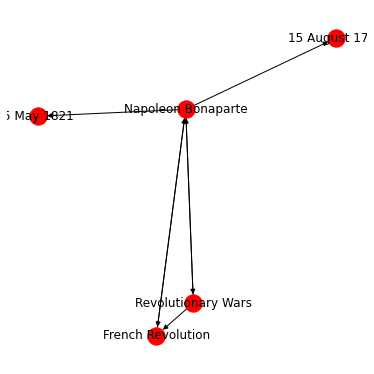

In [8]:
# create a directed-graph from a dataframe
G=nx.from_pandas_edgelist(kg_df, "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())


plt.figure(figsize=(5,5))

pos = nx.spring_layout(G)
nx.draw(G, with_labels=True, node_color='red', edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

# Build a Knowledge Graph
**Case II: Long text**

In [9]:
class KB():
    def __init__(self):
        self.relations = []

    def are_relations_equal(self, r1, r2):
        return all(r1[attr] == r2[attr] for attr in ["head", "type", "tail"])

    def exists_relation(self, r1):
        return any(self.are_relations_equal(r1, r2) for r2 in self.relations)

    def merge_relations(self, r1):
        r2 = [r for r in self.relations
              if self.are_relations_equal(r1, r)][0]
        spans_to_add = [span for span in r1["meta"]["spans"]
                        if span not in r2["meta"]["spans"]]
        r2["meta"]["spans"] += spans_to_add

    def add_relation(self, r):
        if not self.exists_relation(r):
            self.relations.append(r)
        else:
            self.merge_relations(r)

    def print(self):
        print("Relations:")
        for r in self.relations:
            print(f"  {r}")

In [10]:
import math
import torch

def from_text_to_kb(text, span_length=128, verbose=False):
    # tokenize whole text
    inputs = tokenizer([text], return_tensors="pt")

    # compute span boundaries
    num_tokens = len(inputs["input_ids"][0])
    if verbose:
        print(f"Input has {num_tokens} tokens")
    num_spans = math.ceil(num_tokens / span_length)
    if verbose:
        print(f"Input has {num_spans} spans")
    overlap = math.ceil((num_spans * span_length - num_tokens) / 
                        max(num_spans - 1, 1))
    spans_boundaries = []
    start = 0
    for i in range(num_spans):
        spans_boundaries.append([start + span_length * i,
                                 start + span_length * (i + 1)])
        start -= overlap
    if verbose:
        print(f"Span boundaries are {spans_boundaries}")

    # transform input with spans
    tensor_ids = [inputs["input_ids"][0][boundary[0]:boundary[1]]
                  for boundary in spans_boundaries]
    tensor_masks = [inputs["attention_mask"][0][boundary[0]:boundary[1]]
                    for boundary in spans_boundaries]
    inputs = {
        "input_ids": torch.stack(tensor_ids),
        "attention_mask": torch.stack(tensor_masks)
    }

    # generate relations
    num_return_sequences = 3
    gen_kwargs = {
        "max_length": 256,
        "length_penalty": 0,
        "num_beams": 3,
        "num_return_sequences": num_return_sequences
    }
    generated_tokens = model.generate(
        **inputs,
        **gen_kwargs,
    )

    # decode relations
    decoded_preds = tokenizer.batch_decode(generated_tokens,
                                           skip_special_tokens=False)

    # create kb
    kb = KB()
    i = 0
    for sentence_pred in decoded_preds:
        current_span_index = i // num_return_sequences
        relations = extract_relations_from_model_output(sentence_pred)
        for relation in relations:
            relation["meta"] = {
                "spans": [spans_boundaries[current_span_index]]
            }
            kb.add_relation(relation)
        i += 1

    return kb

In [11]:
text = """
Napoleon Bonaparte (born Napoleone di Buonaparte; 15 August 1769 – 5 May 1821), and later known by his regnal name Napoleon I, was a French military and political leader who rose to prominence during the French Revolution and led several successful campaigns during the Revolutionary Wars. He was the de facto leader of the French Republic as First Consul from 1799 to 1804. As Napoleon I, he was Emperor of the French from 1804 until 1814 and again in 1815. Napoleon's political and cultural legacy has endured, and he has been one of the most celebrated and controversial leaders in world history. Napoleon was born on the island of Corsica not long after its annexation by the Kingdom of France.[5] He supported the French Revolution in 1789 while serving in the French army, and tried to spread its ideals to his native Corsica. He rose rapidly in the Army after he saved the governing French Directory by firing on royalist insurgents. In 1796, he began a military campaign against the Austrians and their Italian allies, scoring decisive victories and becoming a national hero. Two years later, he led a military expedition to Egypt that served as a springboard to political power. He engineered a coup in November 1799 and became First Consul of the Republic. Differences with the British meant that the French faced the War of the Third Coalition by 1805. Napoleon shattered this coalition with victories in the Ulm Campaign, and at the Battle of Austerlitz, which led to the dissolving of the Holy Roman Empire. In 1806, the Fourth Coalition took up arms against him because Prussia became worried about growing French influence on the continent. Napoleon knocked out Prussia at the battles of Jena and Auerstedt, marched the Grande Armée into Eastern Europe, annihilating the Russians in June 1807 at Friedland, and forcing the defeated nations of the Fourth Coalition to accept the Treaties of Tilsit. Two years later, the Austrians challenged the French again during the War of the Fifth Coalition, but Napoleon solidified his grip over Europe after triumphing at the Battle of Wagram. Hoping to extend the Continental System, his embargo against Britain, Napoleon invaded the Iberian Peninsula and declared his brother Joseph King of Spain in 1808. The Spanish and the Portuguese revolted in the Peninsular War, culminating in defeat for Napoleon's marshals. Napoleon launched an invasion of Russia in the summer of 1812. The resulting campaign witnessed the catastrophic retreat of Napoleon's Grande Armée. In 1813, Prussia and Austria joined Russian forces in a Sixth Coalition against France. A chaotic military campaign resulted in a large coalition army defeating Napoleon at the Battle of Leipzig in October 1813. The coalition invaded France and captured Paris, forcing Napoleon to abdicate in April 1814. He was exiled to the island of Elba, between Corsica and Italy. In France, the Bourbons were restored to power. However, Napoleon escaped Elba in February 1815 and took control of France.[6][7] The Allies responded by forming a Seventh Coalition, which defeated Napoleon at the Battle of Waterloo in June 1815. The British exiled him to the remote island of Saint Helena in the Atlantic, where he died in 1821 at the age of 51. Napoleon had an extensive impact on the modern world, bringing liberal reforms to the many countries he conquered, especially the Low Countries, Switzerland, and parts of modern Italy and Germany. He implemented liberal policies in France and Western Europe.
"""

kb = from_text_to_kb(text, verbose=True)
kb.print()

Input has 726 tokens
Input has 6 spans
Span boundaries are [[0, 128], [119, 247], [238, 366], [357, 485], [476, 604], [595, 723]]
Relations:
  {'head': 'Napoleon Bonaparte', 'type': 'date of birth', 'tail': '15 August 1769', 'meta': {'spans': [[0, 128]]}}
  {'head': 'Napoleon Bonaparte', 'type': 'date of death', 'tail': '5 May 1821', 'meta': {'spans': [[0, 128]]}}
  {'head': 'Napoleon Bonaparte', 'type': 'participant in', 'tail': 'French Revolution', 'meta': {'spans': [[0, 128]]}}
  {'head': 'Napoleon Bonaparte', 'type': 'conflict', 'tail': 'Revolutionary Wars', 'meta': {'spans': [[0, 128]]}}
  {'head': 'Revolutionary Wars', 'type': 'part of', 'tail': 'French Revolution', 'meta': {'spans': [[0, 128]]}}
  {'head': 'French Revolution', 'type': 'participant', 'tail': 'Napoleon Bonaparte', 'meta': {'spans': [[0, 128]]}}
  {'head': 'Revolutionary Wars', 'type': 'participant', 'tail': 'Napoleon Bonaparte', 'meta': {'spans': [[0, 128]]}}
  {'head': 'French Revolution', 'type': 'country', 'tai

In [12]:
# extract subject
source = [x['head'] for x in kb.relations]

# extract relation
relations = [x['type'] for x in kb.relations]

# extract object
target =[x['tail'] for x in kb.relations]

kg_df = pd.DataFrame({'source':source, 'target':target, 'edge':relations})
kg_df

,source,target,edge
0,Napoleon Bonaparte,15 August 1769,date of birth
1,Napoleon Bonaparte,5 May 1821,date of death
2,Napoleon Bonaparte,French Revolution,participant in
3,Napoleon Bonaparte,Revolutionary Wars,conflict
4,Revolutionary Wars,French Revolution,part of
5,French Revolution,Napoleon Bonaparte,participant
6,Revolutionary Wars,Napoleon Bonaparte,participant
7,French Revolution,French Republic,country
8,Napoleon,Corsica,place of birth
9,French Directory,French Revolution,facet of


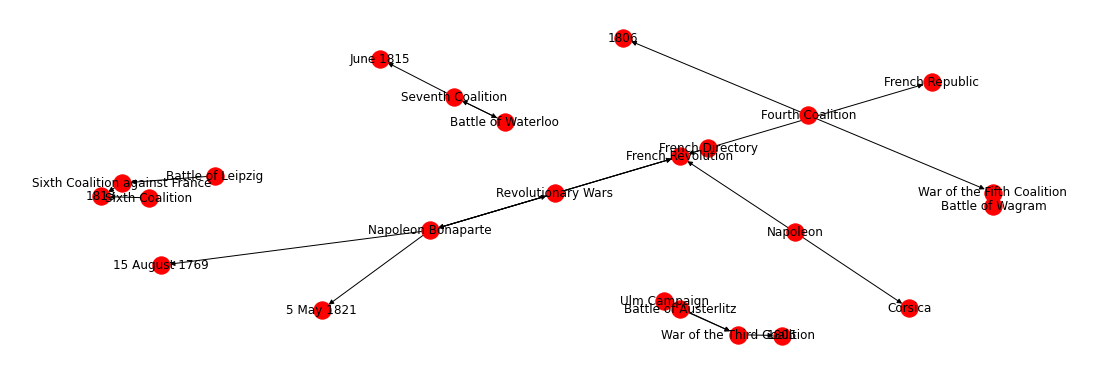

In [13]:
# create a directed-graph from a dataframe
G=nx.from_pandas_edgelist(kg_df, "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())


plt.figure(figsize=(15,5))

pos = nx.spring_layout(G)
nx.draw(G, with_labels=True, node_color='red', edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

## Filter and normalize entities

If you look closely at the extracted relations, you can see that there’s a relation with the entity "Napoleon Bonaparte" and a relation with the entity "Napoleon". How can we tell our knowledge base that the two entities should be treated as the same?

One way to do this is to use the wikipedia library to check if "Napoleon Bonaparte" and "Napoleon" have the same Wikipedia page. If so, they are normalized to the title of the Wikipedia page. If an extracted entity doesn’t have a corresponding Wikipedia page, we ignore it at the moment. This step is commonly called *Entity Linking*.

In [14]:
import wikipedia

class KB():
    def __init__(self):
        self.entities = {}
        self.relations = []

    def are_relations_equal(self, r1, r2):
        return all(r1[attr] == r2[attr] for attr in ["head", "type", "tail"])

    def exists_relation(self, r1):
        return any(self.are_relations_equal(r1, r2) for r2 in self.relations)

    def merge_relations(self, r1):
        r2 = [r for r in self.relations
              if self.are_relations_equal(r1, r)][0]
        spans_to_add = [span for span in r1["meta"]["spans"]
                        if span not in r2["meta"]["spans"]]
        r2["meta"]["spans"] += spans_to_add

    def get_wikipedia_data(self, candidate_entity):
        try:
            page = wikipedia.page(candidate_entity, auto_suggest=False)
            entity_data = {
                "title": page.title,
                "url": page.url,
                "summary": page.summary
            }
            return entity_data
        except:
            return None

    def add_entity(self, e):
        self.entities[e["title"]] = {k:v for k,v in e.items() if k != "title"}

    def add_relation(self, r):
        # check on wikipedia
        candidate_entities = [r["head"], r["tail"]]
        entities = [self.get_wikipedia_data(ent) for ent in candidate_entities]

        # if one entity does not exist, stop
        if any(ent is None for ent in entities):
            return

        # manage new entities
        for e in entities:
            self.add_entity(e)

        # rename relation entities with their wikipedia titles
        r["head"] = entities[0]["title"]
        r["tail"] = entities[1]["title"]

        # manage new relation
        if not self.exists_relation(r):
            self.relations.append(r)
        else:
            self.merge_relations(r)

    def print(self):
        print("Entities:")
        for e in self.entities.items():
            print(f"  {e}")
        print("Relations:")
        for r in self.relations:
            print(f"  {r}")

In [15]:
text = """
Napoleon Bonaparte (born Napoleone di Buonaparte; 15 August 1769 – 5 May 1821), and later known by his regnal name Napoleon I, was a French military and political leader who rose to prominence during the French Revolution and led several successful campaigns during the Revolutionary Wars. He was the de facto leader of the French Republic as First Consul from 1799 to 1804. As Napoleon I, he was Emperor of the French from 1804 until 1814 and again in 1815. Napoleon's political and cultural legacy has endured, and he has been one of the most celebrated and controversial leaders in world history. Napoleon was born on the island of Corsica not long after its annexation by the Kingdom of France.[5] He supported the French Revolution in 1789 while serving in the French army, and tried to spread its ideals to his native Corsica. He rose rapidly in the Army after he saved the governing French Directory by firing on royalist insurgents. In 1796, he began a military campaign against the Austrians and their Italian allies, scoring decisive victories and becoming a national hero. Two years later, he led a military expedition to Egypt that served as a springboard to political power. He engineered a coup in November 1799 and became First Consul of the Republic. Differences with the British meant that the French faced the War of the Third Coalition by 1805. Napoleon shattered this coalition with victories in the Ulm Campaign, and at the Battle of Austerlitz, which led to the dissolving of the Holy Roman Empire. In 1806, the Fourth Coalition took up arms against him because Prussia became worried about growing French influence on the continent. Napoleon knocked out Prussia at the battles of Jena and Auerstedt, marched the Grande Armée into Eastern Europe, annihilating the Russians in June 1807 at Friedland, and forcing the defeated nations of the Fourth Coalition to accept the Treaties of Tilsit. Two years later, the Austrians challenged the French again during the War of the Fifth Coalition, but Napoleon solidified his grip over Europe after triumphing at the Battle of Wagram. Hoping to extend the Continental System, his embargo against Britain, Napoleon invaded the Iberian Peninsula and declared his brother Joseph King of Spain in 1808. The Spanish and the Portuguese revolted in the Peninsular War, culminating in defeat for Napoleon's marshals. Napoleon launched an invasion of Russia in the summer of 1812. The resulting campaign witnessed the catastrophic retreat of Napoleon's Grande Armée. In 1813, Prussia and Austria joined Russian forces in a Sixth Coalition against France. A chaotic military campaign resulted in a large coalition army defeating Napoleon at the Battle of Leipzig in October 1813. The coalition invaded France and captured Paris, forcing Napoleon to abdicate in April 1814. He was exiled to the island of Elba, between Corsica and Italy. In France, the Bourbons were restored to power. However, Napoleon escaped Elba in February 1815 and took control of France.[6][7] The Allies responded by forming a Seventh Coalition, which defeated Napoleon at the Battle of Waterloo in June 1815. The British exiled him to the remote island of Saint Helena in the Atlantic, where he died in 1821 at the age of 51. Napoleon had an extensive impact on the modern world, bringing liberal reforms to the many countries he conquered, especially the Low Countries, Switzerland, and parts of modern Italy and Germany. He implemented liberal policies in France and Western Europe.
"""

kb = from_text_to_kb(text)
kb.print()

c:\Users\poseidon\anaconda\envs\NLP\lib\site-packages\wikipedia\wikipedia.py:389: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file c:\Users\poseidon\anaconda\envs\NLP\lib\site-packages\wikipedia\wikipedia.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  lis = BeautifulSoup(html).find_all('li')


Entities:
  ('Napoleon', {'url': 'https://en.wikipedia.org/wiki/Napoleon', 'summary': "Napoleon Bonaparte (born Napoleone Buonaparte; 15 August 1769 – 5 May 1821), later known by his regnal name Napoleon I, was a French military commander and political leader who rose to prominence during the French Revolution and led successful campaigns during the Revolutionary Wars. He was the de facto leader of the French Republic as First Consul from 1799 to 1804, then Emperor of the French from 1804 until 1814 and again in 1815. Napoleon's political and cultural legacy endures to this day, as a highly celebrated and controversial leader. He initiated many liberal reforms that have persisted in society, and is considered one of the greatest military commanders in history. His wars and campaigns are studied by militaries all over the world. Between three and six million civilians and soldiers perished in what became known as the Napoleonic Wars.Napoleon was born on the island of Corsica, not long a

In [16]:
# extract subject
source = [x['head'] for x in kb.relations]

# extract relation
relations = [x['type'] for x in kb.relations]

# extract object
target =[x['tail'] for x in kb.relations]

kg_df = pd.DataFrame({'source':source, 'target':target, 'edge':relations})
kg_df

,source,target,edge
0,Napoleon,French Revolution,participant in
1,French Revolution,Napoleon,participant
2,French Revolution,France,country
3,Napoleon,Corsica,place of birth
4,French Directory,French Revolution,facet of
5,War of the Fourth Coalition,1806,start time
6,Ulm campaign,War of the Third Coalition,part of
7,Battle of Austerlitz,War of the Third Coalition,part of
8,War of the Third Coalition,1805,start time
9,Battle of Wagram,War of the Fifth Coalition,part of


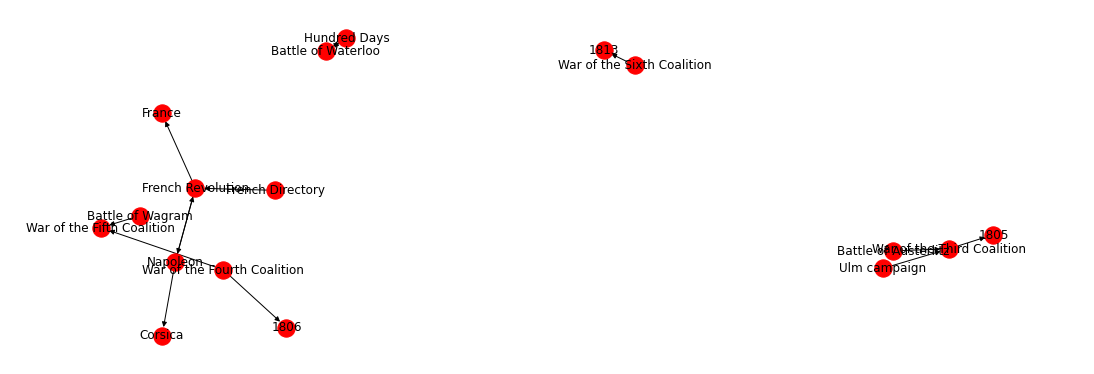

In [19]:
# create a directed-graph from a dataframe
G=nx.from_pandas_edgelist(kg_df, "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())


plt.figure(figsize=(15,5))

pos = nx.spring_layout(G)
nx.draw(G, with_labels=True, node_color='red', edge_cmap=plt.cm.Blues, pos = pos)
plt.show()